### Working question - what is SuperFoodsMax revenue forecast over next 24 months?

In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose #library for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
statsmodels.__version__

'0.12.2'

In [3]:
#Create a dataframe based on the SuperFoodsMax dataset
df = pd.read_csv("dataset_2017_2020_cleanJP.csv")

In [4]:
#List the columns in the dataset
df.columns

Index(['Unnamed: 0', 'customer_id', 'product_id', 'basket_id', 'loyalty',
       'household_type', 'age_band', 'department', 'brand', 'commodity',
       'store', 'transaction_date', 'price', 'days_since_first', 't_date',
       'month', 'quarter', 'demo_child'],
      dtype='object')

In [5]:
#Standardise dates in the dataframe to transform dates to the first day of the month and remove time references. 
#Note the new t_date variable
df['transaction_date'] = df.transaction_date.str[:10] #avoid time in date
df['t_date'] = pd.to_datetime(df.transaction_date) #convert to date format
df['t_date'] = df.t_date + pd.offsets.MonthBegin(-1) #send dates to first day of the month

In [6]:
df.head()

,Unnamed: 0,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date,month,quarter,demo_child
0,0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,2018-10-18,0.99,0,2018-10-01,10,Q4,kids
1,1,15803,1051516,57266,Loyalist,1 adult with kids,19-24,Produce,national,Vegetables - all others,374,2018-10-18,0.70,0,2018-10-01,10,Q4,kids
2,2,15803,967254,57266,Loyalist,1 adult with kids,19-24,Pharmaceutical,national,Cold and flu,374,2018-10-18,1.68,0,2018-10-01,10,Q4,kids
3,3,15803,1134222,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Paper housewares,374,2018-10-18,2.59,0,2018-10-01,10,Q4,kids
4,4,15803,1003421,57266,Loyalist,1 adult with kids,19-24,Grocery,national,Soup,374,2018-10-18,0.60,0,2018-10-01,10,Q4,kids


In [7]:
#create dataframe that will contain the time series.
ts = df.groupby(['t_date']).agg(total_revenue=('price', sum)).reset_index()

In [8]:
ts.head()

,t_date,total_revenue
0,2017-01-01,5287.93
1,2017-02-01,5690.26
2,2017-03-01,6295.21
3,2017-04-01,5804.32
4,2017-05-01,5461.15


<h2> Training Dataset </h2>

In [9]:
#Grab 3 years of data; we will eventually use this as our training data for our time series model.
training = ts.loc[ts.t_date < '2020-01-01'].set_index('t_date')
training.shape

(36, 1)

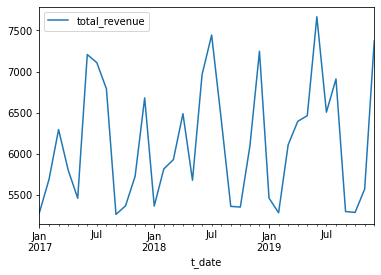

In [10]:
#checking how it looks
training.plot();

<h2> Seasonal Decompose </h2>

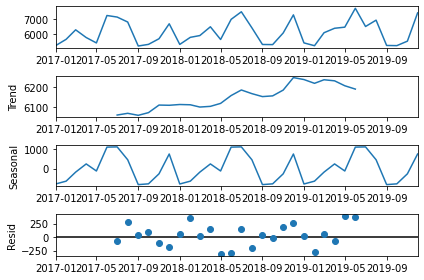

In [11]:
ts_components = seasonal_decompose(training)
ts_components.plot();

### Check for stationarity using mean and variance

In [12]:
#Split the training data in half
split = round(len(training) / 2) # Find mid-point
x1 = training[0:split] # Extract first half
x2 = training[split:]  # Extract second half

# Calculate means
mean1= x1.mean()
mean2= x2.mean()
print("Mean 1 & 2 = ", round(mean1[0]), round(mean2[0]))

# Calculate variances
var1=x1.var()
var2=x2.var()
print("Variance 1 & 2 = ",round(var1[0]), round(var2[0]))

Mean 1 & 2 =  6052 6236
Variance 1 & 2 =  438684 690690



### Check for stationarity using Augmented Dickey-Fuller Test

In [13]:
# Run test:
test_adf = adfuller(training)

#Output the results:
print('ADF test = ', test_adf[0])
print('p-value = ', test_adf[1])

ADF test =  -3.857628515186847
p-value =  0.0023697784488863134



Given that the ADF value is negative and p-value < 0.05, we can reject the null hyphotesis and assume that our time series is stationary



### Check autocorrelation to choose a p parameter for ARIMA model

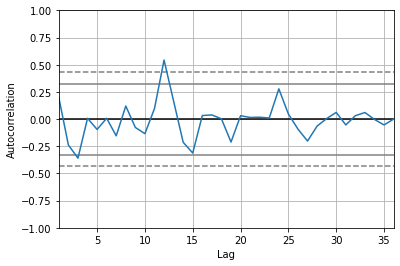

In [14]:
#11
# The autocorrelation plot will help us to define one of the parameters of the ARIMA model (parameter p)
# An autocorrelation is the correlation of a signal with a delayed copy of itself.
# When a correlation value is closer to 0 it is telling us that there is randomness in our data; 
# a correlation of 1 (or -1) means we can use the delayed series to predict the current series entirely (which is ideal and uncommon). 

autocorrelation_plot(training);



### Define a test dataset

In [15]:
# Extract all data after and including Jan 2020.
test = ts.loc[ts.t_date >= '2020-01-01'].set_index('t_date')

# Have a look at our test datset:
print(test)

            total_revenue
t_date                   
2020-01-01        5242.21
2020-02-01        6205.57
2020-03-01        5835.69
2020-04-01        6380.56
2020-05-01        6235.96


### Prepare data for ARIMA model

In [21]:
# Transform our data in a series, where the index is the time series
whole = ts.set_index('t_date').squeeze().copy()
# history is going to countain our training data as a time series
history = whole.take(range(36))
# future contains the test data, also as a time series
future = test.squeeze().copy()

In [22]:
for t in range(len(future)):
    
    # create our model using our dataset, specify the parameters of the method, p=3, d=0 as our data is stationary, q=0
    # parameter freq is used to define the frequency we have our data on, in this case it's MS or MonthStart
    model = ARIMA(history, order=(3,0,0), freq='MS')
    
    # use the fit method so the model is prepared with the training data
    model_fit = model.fit(disp=0)
    
    # use the forecast method to compute the predictions, in this case we just want the prediction for the next month
    # change steps value to increase the prediction range
    # Output will return three values:
    # 0 - the list of predicted values with size steps 
    # 1 - the calculated standard error of the prediction
    # 2 - the confidence interval of the prediction given the standard error
    output = model_fit.forecast(steps=1)
    
    # yhat is the value predicted by the model, in this case just one month
    yhat = output[0].round(2) 
    # stderr is the standard error of the prediction:
    stderr = output[1].round(2) 
    
    #confint is the confidnece interval given the standard error:
    confint = output[2].round(2) 
    
    # obs is the actual value observed for the predicted month, so we will compare predicted value v observed (real) value
    month = future.index[t]
    obs = future[t].round(2)
    
    # print the forecast revenue vs the observed revenue (since Jan 2020)
    print(month)
    print('prediction:', yhat, ', expected:', obs, ', stderr:', stderr, ', conf. int:', confint)
    
    # note that with each run, ARIMA will be run with the last observed value, so we just extend from the original time series
    history = whole.take(range(36 + t+1))
    

2020-01-01 00:00:00
prediction: [6816.96] , expected: 5242.21 , stderr: [648.91] , conf. int: [[5545.12 8088.79]]
2020-02-01 00:00:00
prediction: [5947.88] , expected: 6205.57 , stderr: [685.39] , conf. int: [[4604.53 7291.22]]
2020-03-01 00:00:00
prediction: [5930.47] , expected: 5835.69 , stderr: [677.28] , conf. int: [[4603.02 7257.91]]
2020-04-01 00:00:00
prediction: [6348.98] , expected: 6380.56 , stderr: [668.6] , conf. int: [[5038.54 7659.41]]
2020-05-01 00:00:00
prediction: [6176.65] , expected: 6235.96 , stderr: [660.18] , conf. int: [[4882.73 7470.57]]


### Forecast new data into the future.
Forecasting 12 steps forward. The prediction is extended to investigate data from June 2020 to May 2021.

In [23]:
# Predict the revenue of the next 12 months (from June 2020 to May 2021)
# Running ARMA again so it captures the last observed value

model = ARIMA(history, order=(3,0,0), freq='MS')
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=24)

### Interpret the results of our forecast

In [24]:
output[0].round(2) # The first set of output shows the predicted values for the following twelve months.

array([6187.48, 6046.13, 6083.43, 6123.55, 6162.75, 6148.99, 6129.72,
       6118.65, 6124.75, 6132.72, 6135.73, 6132.94, 6129.87, 6129.15,
       6130.39, 6131.52, 6131.64, 6131.1 , 6130.71, 6130.72, 6130.94,
       6131.08, 6131.05, 6130.96])

The revenue is predicted to remain steady with little trends.

While we can train and make predictions with our model, the autocorrelation plot showed us that there is a random effect in our data, so the predictions done with our method will be less accurate.

In [25]:
# Confidence intervals:
output[2].round(2)

array([[4909.34, 7465.62],
       [4762.71, 7329.55],
       [4785.61, 7381.25],
       [4762.13, 7484.96],
       [4800.73, 7524.78],
       [4781.83, 7516.15],
       [4755.62, 7503.83],
       [4744.54, 7492.77],
       [4749.49, 7500.01],
       [4756.67, 7508.77],
       [4759.68, 7511.78],
       [4756.68, 7509.21],
       [4753.52, 7506.22],
       [4752.8 , 7505.51],
       [4754.  , 7506.78],
       [4755.13, 7507.92],
       [4755.24, 7508.04],
       [4754.7 , 7507.51],
       [4754.3 , 7507.11],
       [4754.32, 7507.13],
       [4754.54, 7507.35],
       [4754.67, 7507.48],
       [4754.64, 7507.46],
       [4754.55, 7507.37]])